In [1]:
%matplotlib inline 
from IPython.display import display, HTML
import pandas as pd 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
import os 
import numpy as np 
import pylab as pl
import scipy.stats as st
#import plots as plt
import glob 

In [2]:
from ifis_tools import database_tools as db
from ifis_tools import series_tools as ser

In [3]:
import hydroeval as heval

# Definition of Variables and functions 

In [4]:
#Obtains the stations at IFIS
USGSatIFIS = db.SQL_USGS_at_IFIS()
#Links of interes
Links = [368221, 434514,399711,434478, 399598, 418967, 434365, 483619,
    197517, 217531, 197506, 197489, 197446, 202584, 279554,
    313410, 216755, 157521, 216714, 157405, 216572, 178160,
    326674, 326618, 487254, 487052, 448250, 486916, 484173, 503197]

In [5]:
def Read_Qobs(linkID):
    for k in USGSatIFIS.keys():
        if USGSatIFIS[k] == linkID:
            USGS_id = k
    Qobs = db.SQL_read_USGS_Streamflow(USGS_id, '2008-1-1','2018-12-31')
    return Qobs['val']
def MedianByInterval(RCobs, RCsim, bins = np.linspace(0,1,6)):
    Ps = [0]
    X = [0]
    for b1,b2 in zip(bins[:-1],bins[1:]):
        pos = np.where((RCobs>b1)&(RCobs<=b2))[0]
        if pos.size>0:
            Ps.append(np.percentile(RCsim[pos], 50))
        else:
            Ps.append(np.nan)
        X.append((b1+b2)/2.)
    return np.array(Ps), np.array(X)

In [6]:
path = '/media/nicolas/Data/RunoffExp/Results/'

In [7]:
import glob 

In [8]:
L = glob.glob('/media/nicolas/Data/RunoffExp/Results/HLM254/*_003.msg')

## All analysis 

Here we perform the analysis of base separation and runoff for all the stations of the turkey basin.
Then we put the information in three dictionaries Qsim, Qobs, and Events. In each one we put information regarding **RC**, **rainfall**

In [14]:
#Dictionary with links for sub-basins
LinksDict = {'Turkey':[434514,399711,434478, 399598, 418967, 434365, 483619],
         'Maquoketa': [368221],
         'Raccoon': [197517, 217531, 197506, 197489, 197446, 202584, 279554],
         'Nishnabotna':[313410, 216755, 157521, 216714, 157405, 216572, 178160],
         'Sioux':[326674, 326618, 487254, 487052, 448250, 486916, 484173, 503197]}

# Big dictionary 
BigSim = {}
BigObs = {}
BigEvents = {}

#Iterate in the basins
for k in LinksDict.keys():
    
    Links = LinksDict[k]
    
    #Dictionaries with all
    Qsim = {}
    Qobs = {}
    Events = {}
    
    #Iterate in the links
    for link in Links:
        try:
            #Read the data
            qobs = Read_Qobs(link)
            Qhlm = pd.read_msgpack(path + 'HLM190/'+str(link)+'_190.msg')
            Rain = pd.read_msgpack(path + 'Rainfall/Rain_'+str(link)+'.msg')
            #Read data and separate flux
            qobs, Qrun, QsepO = ser.Runoff_SeparateBaseflow(qobs, Qhlm)
            #Mean anual maximum 
            Qmax = qobs.resample('A').max().mean()
            Area = db.SQL_Get_linkArea(link)
            #Find events and estimates observed RC
            pos1, pos2 = ser.Runoff_FindEvents(qobs, Qrun, minPeak=Qmax*0.2)
            RCobs = ser.Runoff_CompleteAnalysis(Area, qobs, Rain, QsepO, pos1, pos2, N = pd.Timedelta('2d'))
            #Updates observed dictionary
            Qobs.update({str(link): {'Q':qobs, 'BR': QsepO, 'RC': RCobs['RC'], 'Rain': RCobs['RainEvent']}})
            #Updates dictionary with events 
            Events.update({str(link): {'p1': pos1, 'p2':pos2}})
            #Read the model 
            QsimT = {}
            for config in ['01','003','005','007','012']:
                #read data and separate baseflow
                qs = pd.read_msgpack(path + 'HLM254/'+str(link)+'_'+config+'.msg')
                qs, Qrun, qsepS = ser.Runoff_SeparateBaseflow(qs, Qhlm)
                #Estimates Runoff 
                RC = ser.Runoff_CompleteAnalysis(Area, qs, Rain, qsepS, pos1, pos2, N = pd.Timedelta('2d'))
                #Update dictionary with simulations and separated baseflow
                QsimT.update({config: {'Q':qs, 'BR':qsepS, 'RC': RC['RC']}})
            Qsim.update({str(link): QsimT})
        except:
            pass
    # Update dictionaries 
    BigObs.update({k:Qobs})
    BigSim.update({k:Qsim})
    BigEvents.update({k:Events})
    #update where it is
    print(k)

Turkey
Maquoketa
Raccoon
Nishnabotna


/usr/local/lib/python3.6/dist-packages/ifis_tools/series_tools.py:269: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ifis_tools/series_tools.py:269: RuntimeWarning:

invalid value encountered in double_scalars



Sioux


The next step consist on the estimation of the **Nash Sutcliffe** ($NE$) and **Kling Gupta** ($KG$) efficiencies for each realization of the model with different values of $T_l$.  From $NE$ and $KG$ we select the best realization of the model and compare its $RC_{tl}$ with the runoff coefficient obtained with $T_l = 0.1m$ ($RC_{0.1}$)

In [63]:
BigKG = {}
BigNE = {}

for k1 in LinksDict.keys():
    
    Qobs = BigObs[k1]
    Qsim = BigSim[k1]
    
    KG = {}
    NE = {}
    
    for m in ['012','01','007','005','003']:
        for k in Qsim.keys():
            Ls = []
            Lo = []
            for ano in range(2012, 2018):
                ind = Qsim[k][m]['Q'][str(ano)+'-4':str(ano)+'-11'].index
                Ls.extend(Qsim[k][m]['Q'][str(ano)+'-4':str(ano)+'-11'].values.tolist())
                Lo.extend(Qobs[k]['Q'][ind].values.tolist())
            NE.update({m:heval.evaluator(heval.nse, np.array(Ls),np.array(Lo))[0]})
            KG.update({m:heval.evaluator(heval.kge, np.array(Ls),np.array(Lo))[0][0]})
    
    BigKG.update({k1:KG})
    BigNE.update({k1:NE})
            
# p1 = Events[k]['p1']
# p2 = Events[k]['p2']
# N = [eval_nash(Qobs[k]['Q'][p1[p]:p2[p]+n], Qsim[k][m]['Q'][p1[p]:p2[p]+n]) for p in range(p1.size)]
# Nash[m].extend(N)

Code to generate the dispersion plot for all the cases.

## Make the Scatter Figures for all the basins.

In [9]:
def ScatterRCvsRCobs(Qobs, Qsim, NE, KG, path = None, show = False):
    
    data = []
    colors = ['rgb(0, 51, 102)','rgb(204, 204, 0)','rgb(255, 255, 0)','rgb(255, 153, 51)','rgb(255, 102, 0)','rgb(153, 102, 51)']    
    for c,m in zip(colors,['01','012','007','005','003']):
        ObsL = []
        SimL = []
        
        for k in Qsim.keys():    
            ind = Qsim[k][m]['RC'].index
            ObsL.extend(Qobs[k]['RC'][ind].values.tolist())
            SimL.extend(Qsim[k][m]['RC'].values.tolist())
        ObsL = np.array(ObsL)
        SimL = np.array(SimL)
        ObsL2 = ObsL[(np.isfinite(ObsL) & (np.isfinite(SimL)))]
        SimL2 = SimL[(np.isfinite(ObsL) & (np.isfinite(SimL)))]
        Per, X = MedianByInterval(ObsL2, SimL2, bins=np.linspace(0, ObsL2.max(),7))
        #Scatter RCobs Vs RCmodel
        trace = go.Scatter(
            x = ObsL2,
            y = SimL2,
            legendgroup = m,
            mode = 'markers',
            name = 'Tl:%s <br>N: %.2f <br> KG: %.2f' % (m, NE[m], KG[m] ),
            marker = dict(
                color = c,
                ),
            )
        data.append(trace)
        trace = go.Scatter(
            x = X,
            y = Per,
            legendgroup = m,
            #name = 'P50',
            showlegend = False,
            marker = dict(
                color = c,
                ),
            )
        data.append(trace)
    
    trace = go.Scatter(
        x = [0, ObsL2.max()],
        y = [0, ObsL2.max()],
        showlegend = False,        
        line = dict(
            color = 'black',
            width = 1,)
        )
    data.append(trace)
    
    layout = go.Layout(
            width=500,
            height=370,    
        yaxis=dict(
            title='RC simulated',
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                    size=16,
                    color='black'
                ),
        ),
        xaxis = dict(
            title = 'RC observed',
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                    size=16,
                    color='black'
            ),),
        margin=dict(
            l=60,
            r=50,
            b=40,
            t=20,
            pad=4
        ),
    )
    config={'showLink': False}
    fig = go.Figure(data=data, layout=layout)
    if show:
        iplot(fig, filename=path, config = config)
    if path:
        plot(fig, filename=path, auto_open=False, config = config)
        div = plot(fig, include_plotlyjs=False, output_type='div', config = config)
    return div, fig

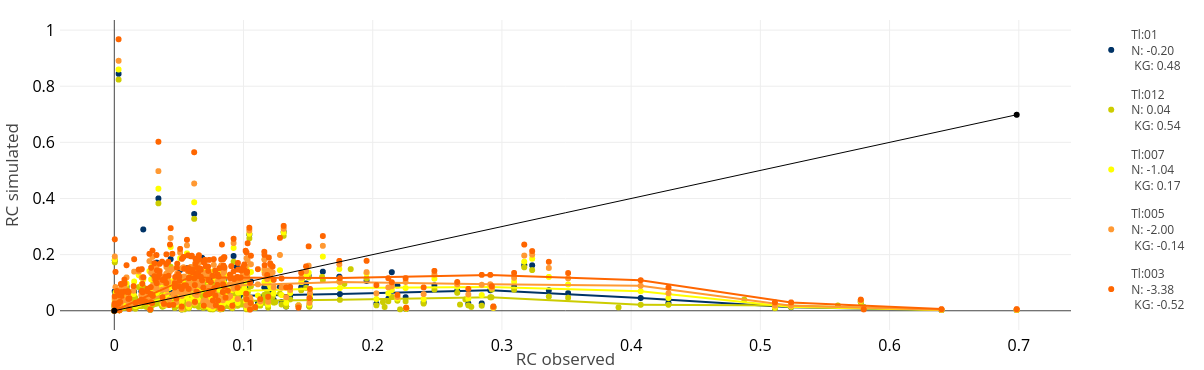

In [72]:
k = 'Sioux'
div, fig = ScatterRCvsRCobs(BigObs[k], BigSim[k], BigNE[k], BigKG[k], path='Figures/Scatter_'+k+'.html', show = True)
#fig.layout.xaxis.title = ''
#fig.layout.yaxis.title = ''
div = plot(fig, include_plotlyjs=False, output_type='div', config = {'showLink': False})

In [ ]:
div

In [29]:
import plots as plt

## Figures of the Events 

In [124]:
def CategorizeEvents(Basin, station):
    
    Qobs = BigObs[Basin][station]['Q']
    Qsim = BigSim[Basin][station]['01']['Q']
    QmaxA = Qobs.resample('A').max().mean()
    DicQmax = {'0.2':[],'0.5':[],'1':[],'1.5':[],'3':[]}
    
    for p1,p2 in zip(BigEvents[Basin][station]['p1'],BigEvents[Basin][station]['p2']):
        Qmax = Qobs[p1-pd.Timedelta('1d'):p2+pd.Timedelta('1d')].max()
        if Qmax > 0.15*QmaxA and Qmax <= 0.3*QmaxA:
            DicQmax['0.2'].append([p1,p2])
        elif Qmax > 0.3*QmaxA and Qmax <= 0.6*QmaxA:
            DicQmax['0.5'].append([p1,p2])
        elif Qmax > 0.8*QmaxA and Qmax <= 1.2*QmaxA:
            DicQmax['1'].append([p1,p2])
        elif Qmax > 1.2*QmaxA and Qmax <= 1.7*QmaxA:
            DicQmax['1.5'].append([p1,p2])
        elif Qmax > 1.7*QmaxA and Qmax <= 5*QmaxA:
            DicQmax['3'].append([p1,p2])
    return DicQmax

In [125]:
DicQmax = CategorizeEvents('Turkey','434514')

In [392]:
def Plot_Events(Basin, station, mag, path = None, extI = pd.Timedelta('1d'), extF = pd.Timedelta('2d'), show = True):
    
    p = DicQmax[mag][np.random.choice(len(DicQmax[mag]))]

    data = []
    colors = ['rgb(0, 51, 102)','rgb(204, 204, 0)','rgb(255, 255, 0)','rgb(255, 153, 51)','rgb(255, 102, 0)','rgb(153, 102, 51)']    
    
    Qobs = BigObs[Basin][station]['Q']
    Qobs[Qobs<0] = np.nan
    St = ['%.2f' % i for i in Qobs[p[0]-extI:p[1]+extF].values]
    St = np.array([float(i) for i in St])
    trace = go.Scatter(
        x = Qobs[p[0]-extI:p[1]+extF].index,
        y = St,
        name = 'Observed',
        marker = dict(
            color = 'black',
            ),
        )
    data.append(trace)
    for c,m in zip(colors,['01','012','007','005','003']):
        #Extract values and evaluate
        Qsim = BigSim[Basin][station][m]['Q']
        nse = heval.evaluator(heval.nse, Qsim[p[0]-extI:p[1]+extF].values, Qobs[p[0]-extI:p[1]+extF].values)[0]
        kg = heval.evaluator(heval.kge, Qsim[p[0]-extI:p[1]+extF].values, Qobs[p[0]-extI:p[1]+extF].values)[0][0]
        
        St = ['%.2f' % i for i in Qsim[p[0]-extI:p[1]+extF].values]
        St = np.array([float(i) for i in St])
        
        #Figure data
        trace = go.Scatter(
            x = Qsim[p[0]-extI:p[1]+extF].index,
            y = St,
            name = 'Tl:%s <br>N: %.2f <br> KG: %.2f' % (m, nse, kg),
            marker = dict(
                color = c,
                size = 6,
                ),
            )
        data.append(trace)

    layout = go.Layout(
            width=1000,
            height=350,    
        yaxis=dict(
            title='Streamflow [m^3.s-1]',
            titlefont = dict(
                size = 16
            ),
            tickfont=dict(
                size=15,
                color='black'
            ),
        ),
        xaxis = dict(
            titlefont = dict(
                size = 16
            ),
            tickfont=dict(
                size=15,
                color='black'
            ),
        ),
        legend=dict(orientation="h",
            x = 1, y = -0.2),
        margin=dict(
            l=60,
            r=60,
            b=30,
            t=20,
            pad=4
        ),
    )
    config={'showLink': False}
    fig = go.Figure(data=data, layout=layout)
    if show:
        iplot(fig, filename=path, config = config)
    if path:
        plot(fig, filename=path, auto_open=False, config = config)
        div = plot(fig, include_plotlyjs=False, output_type='div', config = config)
    return div, fig

def RCplot_Scatter(D, Title='', colorColumn = 'RainInt', path = None):
    '''Plots the RC of a pandas Dataset and stores the html.'''
    #Obtains the text to put in the markers.
    Text = ['Peak: %.1f \n Int: %.1f' % (i,j) for i,j in zip(D['Qmax'], D['RainInt'])]
    data = []
    
    Rc = ['%.3f' % i for i in D['RC'].values]
    Rc = np.array([float(i) for i in Rc])
    
    Rain = ['%.3f' % i for i in D['RainEvent'].values]
    Rain = np.array([float(i) for i in Rain])
    
    # Create a trace
    trace = go.Scatter(
        x = Rain,
        y = Rc,
        text = Title,
        mode = 'markers',
        marker = dict(
            color = D[colorColumn], #set color equal to a variable
            colorscale='Viridis',
            showscale=True,
            size = 10,
            colorbar=dict(
                title='Intensity [mm/h]'
            ),
        )
    )
    data.append(trace)

    layout = go.Layout(
                title=Title,
                yaxis=dict(
                    title='RC',
                    titlefont = dict(
                        size = 17
                    ),
                    tickfont=dict(
                            size=16,
                            color='black'
                        ),
                ),
                xaxis = dict(
                    title = 'Rainfall [mm]',
                    titlefont = dict(
                        size = 17
                    ),
                    tickfont=dict(
                            size=16,
                            color='black'
                    ),
                ),
                 margin=dict(
                    l=70,
                    r=60,
                    b=50,
                    t=20,
                    pad=4
                ),
            )

    fig = go.Figure(data=data, layout=layout)
    config={'showLink': False}
    # Plot and embed in ipython notebook!
    iplot(fig, filename='basic-scatter')
    if path is not None:
        plot(fig, filename=path, auto_open=False, config = config)
    div = plot(fig, include_plotlyjs=False, output_type='div', config = config)
    return div, fig

def RCplot_boxplot(DicStats, DicStatsH=None, path = None, Title ='Boxplot'):
    '''Make a plot of the boxplots'''
    
    data = []
    c = 1
    xtext = ['%.2f' % np.exp(i) for i in DicStats['X']]
    flag = True
    if DicStatsH is None:
        DicStatsH = DicStats
        flag = False
    ListRC = []
    ListRCh = []
    ListX = []
    ListXh = []
    for rc,rch, x in zip(DicStats['RC'],DicStatsH['RC'], DicStats['X']):
        ListRC.extend(rc.values)
        ListRCh.extend(rch.values)
        ListX.extend(np.ones(rc.values.size)*x)
        ListXh.extend(np.ones(rch.values.size)*x)
    
    trace = go.Box(
        y=ListRC,
        x = ListX,
        name = 'Observed',
        marker = dict(
            color = 'rgb(0,0, 102)',
        )
    )
    data.append(trace)
    if flag:
        trace1 = go.Box(
            y=ListRCh,
            x = ListXh,
            name = 'HLM',
            marker = dict(
                color = 'rgb(0, 110, 110)',
            )
        )
        data.append(trace1)

    layout = go.Layout(
            showlegend = True,
            yaxis=dict(
                title='RC',
                titlefont = dict(
                    size = 17
                ),
                tickfont=dict(
                        size=16,
                        color='black'
                    ),            
            ),
            xaxis = dict(
                title = 'Rainfall [mm]',
                titlefont = dict(
                    size = 17
                ),
                tickfont=dict(
                        size=16,
                        color='black'
                ),
                tickvals = DicStats['X'],
                ticktext = xtext
            ),
            boxmode='group',
            legend=dict(orientation="h"),
              margin=dict(
                    l=70,
                    r=60,
                    b=50,
                    t=20,
                    pad=4
                ),
        )
    fig = go.Figure(data=data, layout=layout)
    config={'showLink': False}
    # Plot and embed in ipython notebook!
    iplot(fig, filename='basic-scatter')
    if path is not None:
        plot(fig, filename=path, auto_open=False, config = config)
    div = plot(fig, include_plotlyjs=False, output_type='div', config = config)
    return div, fig

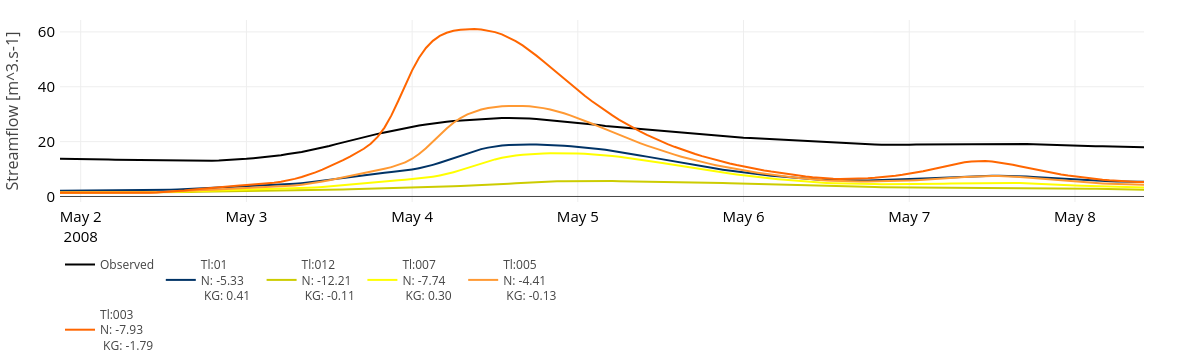

In [355]:
Bas = 'Sioux'
Sta = '448250'
DicQmax = CategorizeEvents(Bas,Sta)
div, fig = Plot_Events(Bas, Sta, '0.2',path = 'Figures/Event_'+Bas+'_'+Sta+'_15.html')

In [225]:
DicAll = {}
DicAllH005 = {}
DicAllH01 = {}
DicAllH003 = {}

In [404]:
#Read the data for turkey
Links = [434514,399711,434478, 399598, 418967, 434365, 483619]
Links = LinksDict['Maquoketa']

ListD = []
ListDhlm15 = []
ListDhlm05 = []
ListDhlm03 = []
ListDhlm01 = []
ListGood = []
for l in Links:
    try:
        ListD.append(pd.read_msgpack(path + 'observed_rc/'+str(l)+'_RC.msg'))
        ListDhlm15.append(pd.read_msgpack(path + 'HLM254/RC_'+str(l)+'_015.msg'))
        ListDhlm05.append(pd.read_msgpack(path + 'HLM254/RC_'+str(l)+'_005.msg'))
        ListDhlm03.append(pd.read_msgpack(path + 'HLM254/RC_'+str(l)+'_003.msg'))
        ListDhlm01.append(pd.read_msgpack(path + 'HLM254/RC_'+str(l)+'_01.msg'))
        ListGood.append(l)
    except:
        pass
D = pd.concat(ListD)
Dh15 = pd.concat(ListDhlm15)
Dh05 = pd.concat(ListDhlm05)
Dh03 = pd.concat(ListDhlm03)
Dh01 = pd.concat(ListDhlm01)

D = D.drop(D[(D['RC']>0.2)&(D['RainEvent']<30)].index)

Dh05 = Dh05.drop(Dh05[(Dh05['RC']>0.1)&(Dh05['RainEvent']<40)].index)
Dh03 = Dh03.drop(Dh03[(Dh03['RC']>0.1)&(Dh03['RainEvent']<40)].index)
Dh01 = Dh01.drop(Dh01[(Dh01['RC']>0.1)&(Dh01['RainEvent']<40)].index)
Dh15 = Dh15.drop(Dh15[(Dh15['RC']>0.1)&(Dh15['RainEvent']<40)].index)

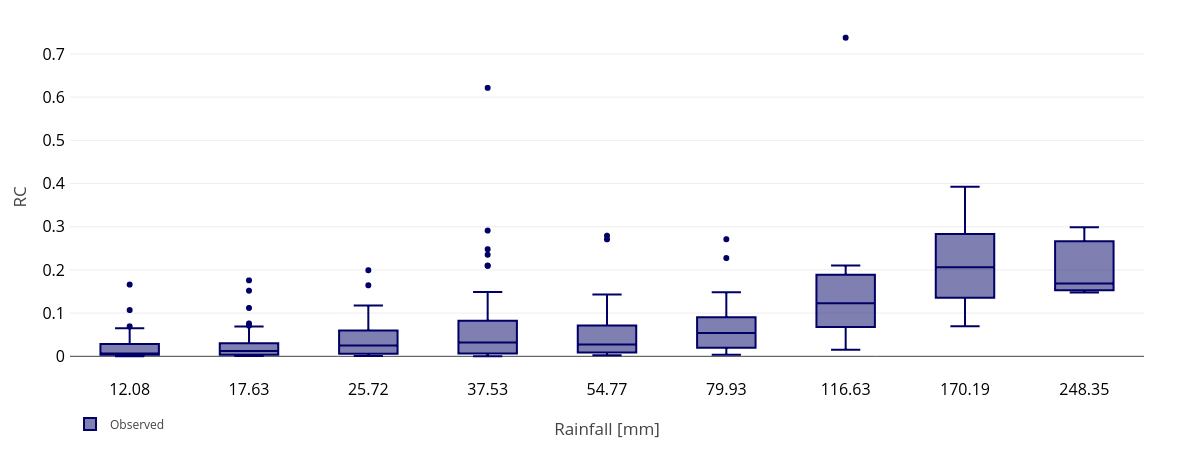

In [405]:
bins = np.linspace(np.log(10),np.log(300),10)
DicStats = ser.Runoff_groupByRain(D, bins = bins)
DicStatsH03 = ser.Runoff_groupByRain(Dh03, bins = bins)
DicStatsH05 = ser.Runoff_groupByRain(Dh05, bins = bins)
DicStatsH01 = ser.Runoff_groupByRain(Dh01, bins = bins)
DicStatsH15 = ser.Runoff_groupByRain(Dh15, bins = bins)
div, fig = RCplot_boxplot(DicStats)

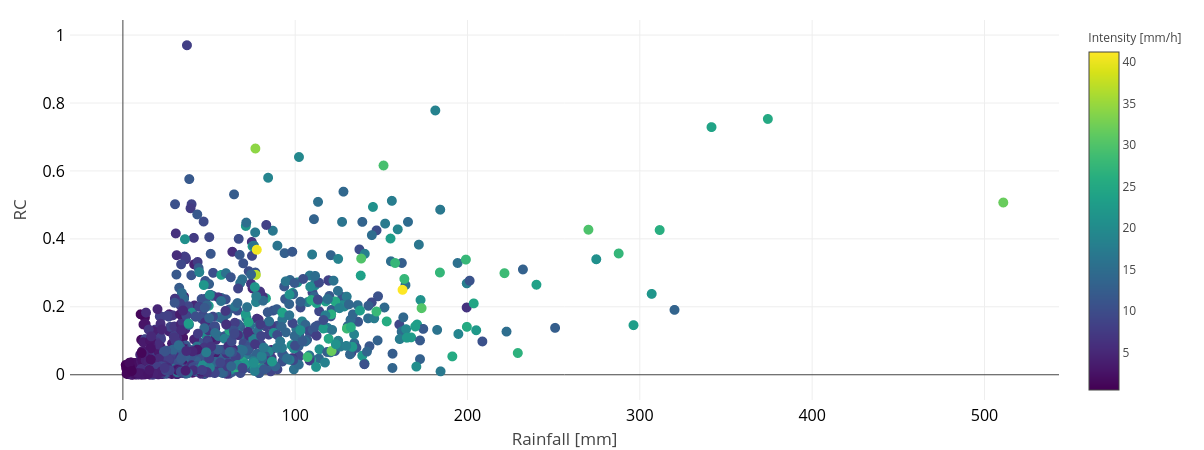

In [389]:
div, fig = RCplot_Scatter(D, path='Figures/Sioux_RC_observed.html')

## Map with best tl and respective Nash and Kg

In [19]:
from psycopg2 import sql

In [57]:
def GetCoordinates(BasinName):
    con = db.DataBaseConnect(user='nicolas',password='10A28Gir0')
    cur = con.cursor()
    LatLng = {}
    for k in BigObs[BasinName].keys():    
        query = sql.SQL('SELECT lat, lng FROM pers_felipe.pois_adv_geom where link_id = '+k)
        cur.execute(query)
        Coord = cur.fetchall()
        LatLng.update({k:[float(Coord[0][0]),float(Coord[0][1])]})         
    con.close()
    return LatLng

In [108]:
def GetPropFromBasin(BasinName):
    Lat = []
    Lon = []
    link = []
    for k in Coord[BasinName].keys():
        Lat.append(Coord[BasinName][k][0])
        Lon.append(Coord[BasinName][k][1])
        link.append(k)
    return Lat, Lon, link

In [107]:
Coord = {}
for k in BigObs.keys():
    Coord.update({k:GetCoordinates(k)})

In [118]:
updatemenus=list([
    # drop-down 1: map styles menu
    # buttons containes as many dictionaries as many alternative map styles I want to offer
    dict(
        buttons=list([
            dict(
                args=['mapbox.style', 'light'],
                label='Light',
                method='relayout'
            ),
            dict(
                args=['mapbox.style', 'dark'],
                label='Dark',
                method='relayout'
            ),                                
            dict(
                args=['mapbox.style', 'outdoors'],
                label='Outdoors',
                method='relayout'
            ),
            dict(
                args=['mapbox.style', 'satellite-streets'],
                label='Satellite with Streets',
                method='relayout'
            )                    
        ]),
        # direction where I want the menu to expand when I click on it
        direction = 'up',
      
        # here I specify where I want to place this drop-down on the map
        x = 0.75,
        xanchor = 'left',
        y = 0.05,
        yanchor = 'bottom',
      
        # specify font size and colors
        bgcolor = '#000000',
        bordercolor = '#FFFFFF',
        font = dict(size=11)
    ), ])

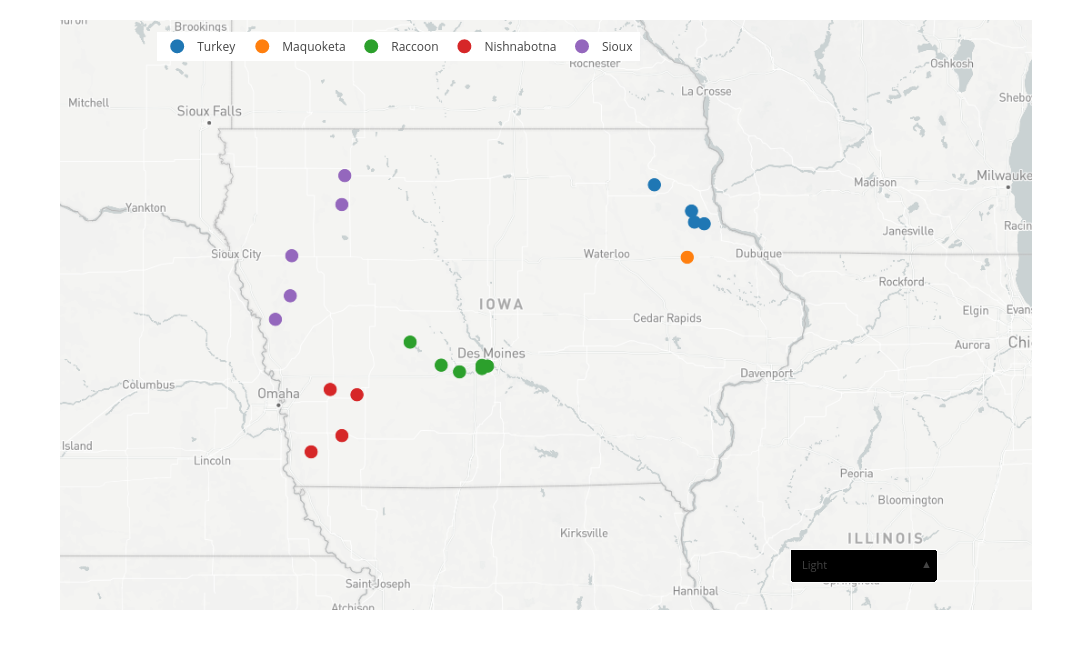

In [146]:

mapbox_access_token = 'pk.eyJ1Ijoibmljb2xhczk5OCIsImEiOiJjanNvcm02OHMwcHhhNDltcDk0Yzhlc2NkIn0.BoQ8-blC4FoYJQr0wMHVmQ'

data = []
for basin in Coord.keys():
    Lat, Lon, linkID = GetPropFromBasin(basin)
    event_data = go.Scattermapbox(
        lat = Lat,
        lon = Lon,
        text = linkID,
        name = basin,
        mode='markers',
        marker=dict(
            size=14,
        ),
    )
    data.append(event_data)

layout = go.Layout(
    width=850,
    height=650,    
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=42.,
            lon=-93
        ),
        # we want the map to be "parallel" to our screen, with no angle
        pitch = 0,
        # default level of zoom
        zoom = 6,
        # default map style
        style = 'light'
    ),
   margin=dict(
    l=60,
    r=50,
    b=40,
    t=20,
    pad=4
    ),
    legend=dict(orientation="h",
        x = 0.1, y = 0.98),
)
layout['updatemenus'] = updatemenus

fig = dict(data=data, layout=layout)

iplot(fig, filename='Montreal Mapbox')
div = plot(fig, include_plotlyjs=False, output_type='div')

In [147]:
div

'<div id="3fbcd6b7-e6b4-4115-87d1-f08d8ba8d989" style="height: 650px; width: 850px;" class="plotly-graph-div"></div><script type="text/javascript">window.PLOTLYENV=window.PLOTLYENV || {};window.PLOTLYENV.BASE_URL="https://plot.ly";Plotly.newPlot("3fbcd6b7-e6b4-4115-87d1-f08d8ba8d989", [{"type": "scattermapbox", "lat": [42.740356, 42.753875, 42.843485, 43.054188], "lon": [-91.261944, -91.369025, -91.401277, -91.809098], "text": ["434514", "399711", "434478", "434365"], "name": "Turkey", "mode": "markers", "marker": {"size": 14}}, {"type": "scattermapbox", "lat": [42.469988], "lon": [-91.448715], "text": ["368221"], "name": "Maquoketa", "mode": "markers", "marker": {"size": 14}}, {"type": "scattermapbox", "lat": [41.581656, 41.587211, 41.561656, 41.534407, 41.589432, 41.778597], "lon": [-93.642996, -93.703276, -93.703554, -93.95032, -94.151346, -94.492749], "text": ["197517", "217531", "197506", "197446", "202584", "279554"], "name": "Raccoon", "mode": "markers", "marker": {"size": 14}},